# Generating sequences

To be able to train neural networks on sequential data, you need to pre-process it first. You'll chunk the data into inputs-target pairs, where the inputs are some number of consecutive data points and the target is the next data point.

Your task is to define a function to do this called create_sequences(). As inputs, it will receive data stored in a DataFrame, df and seq_length, the length of the inputs. As outputs, it should return two NumPy arrays, one with input sequences and the other one with the corresponding targets.

* Iterate over the range of the number of data points minus the length of an input sequence.
* Define the inputs x as the slice of df from the ith row to the i + seq_lengthth row and the column at index 1.
* Define the target y as the slice of df at row index i + seq_length and the column at index 1.

In [60]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchmetrics

In [3]:
df = pd.read_csv("/kaggle/input/electricity-consumption/electricityConsumptionAndProductioction.csv/electricityConsumptionAndProductioction.csv")

In [4]:
df.head()


,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [5]:
# Extract 'timestamp' and 'Consumption' columns
df = df[['DateTime', 'Consumption']]
df.columns = ['timestamp', 'consumption']

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

# Step 2: Resample the data to 1-hour intervals
df = df.resample('H').mean()

/tmp/ipykernel_33/1322871363.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()


In [6]:
df.head()

,consumption
timestamp,
2019-01-01 00:00:00,6352.0
2019-01-01 01:00:00,6116.0
2019-01-01 02:00:00,5873.0
2019-01-01 03:00:00,5682.0
2019-01-01 04:00:00,5557.0


In [7]:
len(df)

46008

In [8]:

# Step 3: Split the data into training and testing sets
train_data = df[:'2023-05-30']  # First three years (up to end of 2022)
test_data = df['2023-06-01':]   # Fourth year (starting from 2023)



In [9]:
print(len(train_data))
print(len(test_data))

38664
7320


In [10]:
train_data

,consumption
timestamp,
2019-01-01 00:00:00,6352.0
2019-01-01 01:00:00,6116.0
2019-01-01 02:00:00,5873.0
2019-01-01 03:00:00,5682.0
2019-01-01 04:00:00,5557.0
...,...
2023-05-30 19:00:00,6309.0
2023-05-30 20:00:00,6411.0
2023-05-30 21:00:00,6647.0


In [13]:
test_data

,consumption
timestamp,
2023-06-01 00:00:00,5136.0
2023-06-01 01:00:00,4943.0
2023-06-01 02:00:00,4778.0
2023-06-01 03:00:00,4726.0
2023-06-01 04:00:00,4701.0
...,...
2024-03-31 19:00:00,5618.0
2024-03-31 20:00:00,6107.0
2024-03-31 21:00:00,5991.0


In [14]:
train_data.shape

(38664, 1)

**Sequential Dataset**

Good job building the create_sequences() function! It's time to use it to create a training dataset for your model.

Just like tabular and image data, sequential data is easiest passed to a model through a torch Dataset and DataLoader. To build a sequential Dataset, you will call create_sequences() to get the NumPy arrays with inputs and targets, and inspect their shape. Next, you will pass them to a TensorDataset to create a proper torch Dataset, and inspect its length.

Your implementation of create_sequences() and a DataFrame with the training data called train_data are available.

Call create_sequences(), passing it the training DataFrame and a sequence length of 24*4, assigning the result to X_train, y_train.
Define dataset_train by calling TensorDataset and passing it two arguments, the inputs and the targets created by create_sequences(), both converted from NumPy arrays to tensors of floats.

In [12]:
# class TimeSeriesDataset(Dataset):
#     def __init__(self, data, seq_length):
#         self.data = data
#         self.seq_length = seq_length
#         self.xs, self.ys = self.create_sequences(data, seq_length)

#     def create_sequences(self, df, seq_length):
#         xs, ys = [], []
#         for i in range(len(df) - seq_length):
#             x = df.iloc[i:(i + seq_length), 0].values  # Use column index 0 for the single column
#             y = df.iloc[i + seq_length, 0]            # Use column index 0 for the single column
#             xs.append(x)
#             ys.append(y)
#         return np.array(xs), np.array(ys)
    
#     def __len__(self):
#         return len(self.xs)

#     def __getitem__(self, idx):
#         return torch.tensor(self.xs[idx], dtype=torch.float32), torch.tensor(self.ys[idx], dtype=torch.float32)

NameError: name 'Dataset' is not defined

In [15]:
def create_sequences(df, seq_length):
    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(df) - seq_length):
      	# Define inputs
        x = df.iloc[i:(i + seq_length), 0]
        # Define target
        y = df.iloc[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

You can now use create_sequences() to create a set of training or testing examples for the model, where each example consists of an input of seq_length consecutive data points, and the single target, the following data point. 

In [16]:
# Define sequence length: 24 hours
seq_length = 24 * 24

# Use create_sequences to create inputs and targets for training data
X_train, y_train = create_sequences(train_data, seq_length)
print(X_train.shape, y_train.shape)

(38088, 576) (38088,)


As you can see from the printed output, we have 38088 training examples, each consisting of 576 inputs and 1 target value. The TensorDataset you have just built behaves the same way as other Torch Datasets you have used before, such us our custom WaterDataset or the ImageFolder dataset; you can pass it to a DataLoader in the same way. With the sequential data ready, let's take a look at model architectures suitable for processing sequential data!

In [45]:
# Convert sequences and labels to PyTorch tensors
sequences = torch.tensor(X_train, dtype=torch.float32)
labels = torch.tensor(y_train, dtype=torch.float32)

# Reshape labels to match output dimensions (e.g., [batch_size, 1])
labels = labels.view(-1, 1)

In [46]:
print(sequences.shape)
print(labels.shape)

torch.Size([38088, 576])
torch.Size([38088, 1])


In [47]:
# Create a TensorDataset and DataLoader
dataset = TensorDataset(sequences, labels)
dataloader_train = DataLoader(dataset, batch_size=32, shuffle=True)

In [20]:
print(dataset)

**Generating TestLoader**

In [28]:
# Define sequence length: 24 hours
seq_length = 24 * 24

# Use create_sequences to create inputs and targets for training data
X_test, y_test = create_sequences(test_data, seq_length)
print(X_test.shape, y_test.shape)

(6744, 576) (6744,)


In [29]:
# Convert sequences and labels to PyTorch tensors
test_sequences = torch.tensor(X_test, dtype=torch.float32)
test_labels = torch.tensor(y_test, dtype=torch.float32)

# Reshape labels to match output dimensions (e.g., [batch_size, 1])
test_labels = test_labels.view(-1, 1)

In [30]:
# Check the shapes of test sequences and labels tensors
print(f'Shape of test_sequences tensor: {test_sequences.shape}')  # Verify the shape
print(f'Shape of test_labels tensor: {test_labels.shape}')    

Shape of test_sequences tensor: torch.Size([6744, 576])
Shape of test_labels tensor: torch.Size([6744, 1])


In [33]:
test_dataset = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Building a forecasting RNN

It's time to build your first recurrent network! It will be a sequence-to-vector model consisting of an RNN layer with two layers and a hidden_size of 32. After the RNN layer, a simple linear layer will map the outputs to a single value to be predicted.

In [21]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define RNN layer
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        # Initialize first hidden state with zeros
        h0 = torch.zeros(2, x.size(0), 32)
        # Pass x and h0 through recurrent layer
        out, _ = self.rnn(x, h0)  
        # Pass recurrent layer's last output through linear layer
        out = self.fc(out[:, -1, :])
        return out

**LSTM network**

As you already know, plain RNN cells are not used that much in practice. A more frequently used alternative that ensures a much better handling of long sequences are Long Short-Term Memory cells, or LSTMs. In this exercise, you will be build an LSTM network yourself!

The most important implementation difference from the RNN network you have built previously comes from the fact that LSTMs have two rather than one hidden states. This means you will need to initialize this additional hidden state and pass it to the LSTM cell.

* In the .__init__() method, define an LSTM layer and assign it to self.lstm.
* In the forward() method, initialize the first long-term memory hidden state c0 with zeros.
* In the forward() method, pass all three inputs to the LSTM layer: the current time step's inputs, and a tuple containing the two hidden states.

In [37]:
class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Define lstm layer
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        # Initialize long-term memory
        c0 = torch.zeros(2, x.size(0), 32)
        # Pass all inputs to lstm layer
        out, _ = self.lstm(x,(h0, c0))
        out = self.fc(out[:, -1, :])
        return out

With only a few updates to the simple RNN's code, you have build a much powerful recurrent model! Let's see if you can do similar adaptations to create a GRU network in the next exercise!

**GRU network**

Next to LSTMs, another popular recurrent neural network variant is the Gated Recurrent Unit, or GRU. It's appeal is in its simplicity: GRU cells require less computation than LSTM cells while often matching them in performance.

The code you are provided with is the RNN model definition that you coded previously. Your task is to adapt it such that it produces a GRU network instead. torch and torch.nn as nn have already been imported for you.

In [38]:
class Net_GRU(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Define RNN layer
        self.rnn = nn.GRU(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.gru(x, h0)  
        out = self.fc(out[:, -1, :])
        return out

Torch makes it very convenient to build different recurrent network flavors without requiring many changes in the code. Now that you know how to build LSTM and GRU models, let's take a look at training and evaluating them!

# Expanding Tensors

Before we take a look at the model training and evaluation, we need to discuss two useful concepts: expanding and squeezing tensors. Let's tackle expanding first. All recurrent layers, RNNs, LSTMs, and GRUs, expect input in the shape: batch size, sequence length, number of features. But as we loop over the DataLoader, we can see that we got the shape batch size of 32 by the sequence length of 576. Since we are dealing with only one feature, the electricity consumption, the last dimension is dropped. We can add it, or expand the tensor, by calling view on the sequence and passing the desired shape.

In [48]:
for seqs,labels in dataloader_train:
    print(seqs.shape)
    break

torch.Size([32, 576])


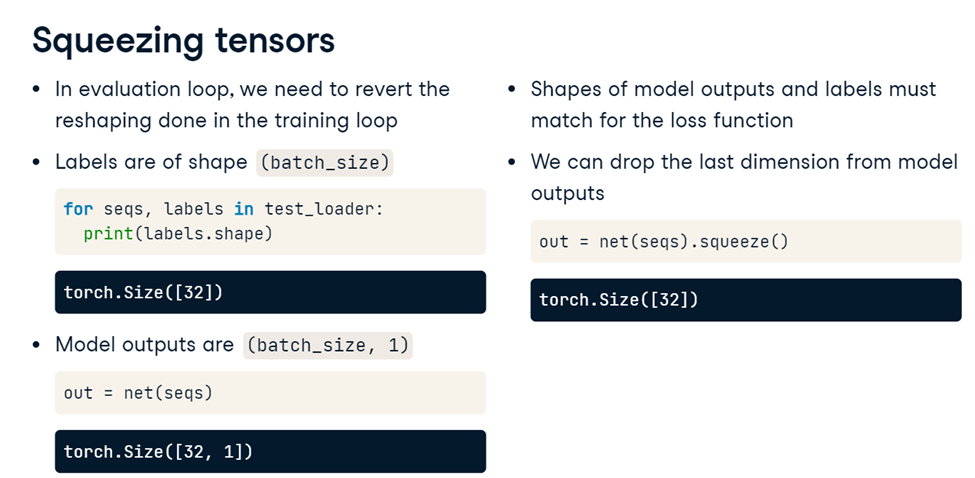!

In [35]:
for seqs, labels in test_loader:
    print(labels.shape)
    break

torch.Size([32, 1])


# RNN training loop

It's time to train the electricity consumption forecasting model!

will use the LSTM network you have defined previously which is available to you as Net, as is the dataloader_train you built before. You will also need to use torch.nn which has already been imported as nn.

In this exercise, you will train the model for only three epochs to make sure the training progresses as expected. Let's get to it!

* Set up the Mean Squared Error loss and assign it to criterion.
* Reshape seqs to (batch size, sequence length, num features), which in our case is (16, 96, 1), and re-assign the result to seqs.
* Pass seqs to the model to get its outputs.
* Based on previously computed quantities, calculate the loss, assigning it to loss.

In [55]:
net = Net(input_size = 1)
# Set up MSE loss
criterion = nn.MSELoss()
optimizer = optim.Adam(
  net.parameters(), lr=0.0001
)

# Training loop with gradient clipping
for epoch in range(3):
    for seqs, labels in dataloader_train:
        batch_size = seqs.size(0)  # Get the actual batch size
        seqs = seqs.view(batch_size, seq_length, 1)  # Reshape model inputs dynamically
        outputs = net(seqs)  # Get model outputs

        # Check for NaNs in the model outputs
        if torch.isnan(outputs).any():
            print("NaNs in outputs detected!")
            break

        loss = criterion(outputs, labels)  # Compute loss

        # Check for NaNs in the loss
        if torch.isnan(loss).any():
            print("NaNs in loss detected!")
            break

        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Ensure no NaNs in test data
print(torch.isnan(test_sequences).sum(), torch.isnan(test_labels).sum())


NaNs in outputs detected!
Epoch 1, Loss: 45655140.0
NaNs in outputs detected!
Epoch 2, Loss: 45655140.0
NaNs in outputs detected!
Epoch 3, Loss: 45655140.0
tensor(20) tensor(1)


In [58]:
# You can now use a similar loop to evaluate the model on test_loader

for epoch in range(3):    
    for seqs, labels in test_loader:
        batch_size = seqs.size(0)
        seqs = seqs.view(batch_size, seq_length, 1)
        outputs = net(seqs)
        loss = criterion(outputs, labels)
        print(f"Test Loss: {loss.item()}")
        
        break

Test Loss: 25963910.0
Test Loss: 25963910.0
Test Loss: 25963910.0


**Evaluating forecasting models**

It's evaluation time! The same LSTM network that you have trained in the previous exercise has been trained for you for a few more epochs and is available as net.

Your task is to evaluate it on a test dataset using the Mean Squared Error metric 

* Define the Mean Squared Error metrics and assign it to mse.
* Pass the input sequence to net, and squeeze the result before you assign it to outputs.
* Compute the final value of the test metric assigning it to test_mse.

In [65]:
import torchmetrics

mse = torchmetrics.MeanSquaredError()

net.eval()
with torch.no_grad():
    for seqs, labels in test_loader:
        batch_size = seqs.size(0)
        seqs = seqs.view(batch_size, -1, 1)  # Adjust reshaping based on batch size
        outputs = net(seqs).squeeze()
        labels = labels.view(-1)  # Adjust the shape of labels to match outputs
        mse(outputs, labels)

# Compute final metric value
test_mse = mse.compute()
print(f"Test MSE: {test_mse}")


Test MSE: nan


You can now prepare sequantial data for model injection, build RNN, LSTM and GRU architectures for time series forecasting, as well as train and evaluate recurrent models. In the final Chapter of the course, we will build multi-input and multi-output models—see you there!